In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DATA VALIDATION REPORT - ALTERNATIVE CREDIT SCORING MODEL")
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Load dữ liệu
df = pd.read_csv('../../data/data-processing/alternative_data/flat_telco.csv')
print(f"\n Loaded {len(df)} records from flat_telco.csv")

DATA VALIDATION REPORT - ALTERNATIVE CREDIT SCORING MODEL
Generated: 2026-01-12 14:38:56

 Loaded 3257 records from flat_telco.csv


In [16]:
# Overview
print("\n" + "="*80)
print("0. TỔNG QUAN DỮ LIỆU")
print("="*80)

print(f"Số dòng: {len(df)}")
print(f"Số cột: {len(df.columns)}")
print(f"\nKiểu dữ liệu:")
print(df.dtypes.value_counts())

print(f"\nDung lượng bộ nhớ: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show sample
print("\n5 dòng đầu tiên:")
print(df.head())


0. TỔNG QUAN DỮ LIỆU
Số dòng: 3257
Số cột: 31

Kiểu dữ liệu:
float64    19
int64       7
object      4
bool        1
Name: count, dtype: int64

Dung lượng bộ nhớ: 1.53 MB

5 dòng đầu tiên:
                                loan_id user_id loan_approval_date  \
0  62fea70f-4391-483f-abb3-1c75ba1efe16  U00004         2024-04-11   
1  8fe7bb2b-f8f1-4ac5-8e60-c36e03e5f9dc  U00005         2023-12-10   
2  3179c3e1-3631-4616-ba58-3eedc7839723  U00009         2024-07-14   
3  fa88c6b3-d47c-4dba-b8e1-4b4916306998  U00012         2024-07-20   
4  36cfa58b-3e44-44cd-a439-b20e91715caf  U00015         2024-08-23   

   loan_amount  loan_term_days  monthly_burden  relative_stress  expected_pd  \
0     14524682             365    1.193809e+06         2.387619     0.170439   
1      4825573             365    3.966224e+05         0.793245     0.137705   
2      4919486             365    4.043413e+05         0.808683     0.126500   
3     13242680             540    7.357044e+05         1.532718     0

In [17]:
# Check Duplicate Records
print("\n" + "="*80)
print("1. CHECK DUPLICATE DATA")
print("="*80)

# Check duplicate loan_id (không nên có)
print(f"Tổng số records: {len(df)}")
print(f"Số loan_id unique: {df['loan_id'].nunique()}")
duplicate_loans = len(df) - df['loan_id'].nunique()
print(f"Số loan_id duplicate: {duplicate_loans}")

if duplicate_loans > 0:
    print("CẢNH BÁO: Có loan_id bị duplicate!")
    print("→ Cần loại bỏ duplicates trước khi train")
    # Show duplicate records
    duplicated_df = df[df.duplicated(subset=['loan_id'], keep=False)]
    print(f"\nCác loan_id bị duplicate:")
    print(duplicated_df[['loan_id', 'user_id', 'loan_approval_date', 'default_flag']].head(10))
else:
    print("Không có loan_id duplicate")

# Check duplicate user_id (được phép, vì 1 user có thể vay nhiều lần)
print(f"\nSố user_id unique: {df['user_id'].nunique()}")
users_with_multiple_loans = df.groupby('user_id').size()
users_with_multiple_loans = users_with_multiple_loans[users_with_multiple_loans > 1]
print(f"Số user có > 1 khoản vay: {len(users_with_multiple_loans)}")
print(f"Tỷ lệ: {len(users_with_multiple_loans)/df['user_id'].nunique()*100:.1f}%")

if len(users_with_multiple_loans) > 0:
    print("\n CHÚ Ý QUAN TRỌNG: Có user vay nhiều lần!")
    print("→ PHẢI tách Train/Test theo USER_ID, KHÔNG theo LOAN_ID!")
    print("→ Tránh data leakage: User A ở train, loan khác của User A ở test.")
    
    # Show examples
    sample_user = users_with_multiple_loans.index[0]
    print(f"\nVí dụ user {sample_user} có {users_with_multiple_loans.iloc[0]} khoản vay:")
    print(df[df['user_id']==sample_user][['loan_id', 'loan_approval_date', 'loan_amount', 'default_flag']])


1. CHECK DUPLICATE DATA
Tổng số records: 3257
Số loan_id unique: 3257
Số loan_id duplicate: 0
Không có loan_id duplicate

Số user_id unique: 3257
Số user có > 1 khoản vay: 0
Tỷ lệ: 0.0%


In [18]:
# Check target variable distribution
print("\n" + "="*80)
print("2. PHÂN PHỐI TARGET VARIABLE (default_flag)")
print("="*80)

default_rate = df['default_flag'].mean()
n_good = (df['default_flag']==0).sum()
n_bad = (df['default_flag']==1).sum()

print(f"Tỷ lệ default: {default_rate:.2%}")
print(f"Số lượng Good (0): {n_good} ({n_good/len(df)*100:.1f}%)")
print(f"Số lượng Bad (1): {n_bad} ({n_bad/len(df)*100:.1f}%)")
print(f"Tỷ lệ Good:Bad = {n_good/n_bad:.2f}:1")

# Đánh giá
if default_rate < 0.05:
    print("\nCẢNH BÁO NGHIÊM TRỌNG: Target quá imbalanced (<5% default)")
    print("→ Data không đủ tốt để train model")
elif default_rate < 0.10:
    print("\nCẢNH BÁO: Target imbalanced (<10% default)")
    print("→ BẮT BUỘC dùng scale_pos_weight trong XGBoost")
    print(f"→ scale_pos_weight = {n_good/n_bad:.2f}")
elif default_rate > 0.50:
    print("\nCẢNH BÁO: Tỷ lệ default quá cao (>50%)")
    print("→ Kiểm tra lại labeling hoặc data collection process")
else:
    print("\nTỷ lệ default hợp lý (10-50%)")
    print(f"→ Khuyến nghị scale_pos_weight = {n_good/n_bad:.2f}")


2. PHÂN PHỐI TARGET VARIABLE (default_flag)
Tỷ lệ default: 16.27%
Số lượng Good (0): 2727 (83.7%)
Số lượng Bad (1): 530 (16.3%)
Tỷ lệ Good:Bad = 5.15:1

Tỷ lệ default hợp lý (10-50%)
→ Khuyến nghị scale_pos_weight = 5.15


In [19]:
# Check Missing data
print("\n" + "="*80)
print("3. PHÂN TÍCH MISSING DATA")
print("="*80)

missing_stats = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': df.isnull().mean() * 100
}).sort_values('Missing_Percent', ascending=False)

# Show top 15 features with missing
print("Top 15 features có missing nhiều nhất:")
print(missing_stats[missing_stats['Missing_Count'] > 0].head(15))

# Critical check
critical_missing = missing_stats[missing_stats['Missing_Percent'] > 50]
if len(critical_missing) > 0:
    print(f"\nCẢNH BÁO: {len(critical_missing)} features có missing >50%:")
    print(critical_missing)
    print("\n→ Cân nhắc DROP các features này HOẶC tạo 'has_data' flag")
else:
    print("\nKhông có feature nào missing >50%")

# Check missing pattern
print(f"\nTổng số records HOÀN TOÀN KHÔNG missing: {df.dropna().shape[0]} ({df.dropna().shape[0]/len(df)*100:.1f}%)")

# Feature missing ratio analysis
if 'feature_missing_ratio' in df.columns:
    print(f"\nPhân phối feature_missing_ratio:")
    print(df['feature_missing_ratio'].describe())
    
    high_missing_records = df[df['feature_missing_ratio'] > 0.4]
    print(f"\nSố records có >40% features missing: {len(high_missing_records)} ({len(high_missing_records)/len(df)*100:.1f}%)")
    
    if len(high_missing_records) > 0:
        print("CHÚ Ý: Nhiều records thiếu data → Model có thể kém chính xác")



3. PHÂN TÍCH MISSING DATA
Top 15 features có missing nhiều nhất:
                            Missing_Count  Missing_Percent
prior_default_rate                   3257       100.000000
has_academic                         3197        98.157814
education_level_encoded              3197        98.157814
gpa_high_flag                        3197        98.157814
dropout_flag                         3197        98.157814
max_consecutive_block_days           3143        96.499846
max_topup_gap_days                   3095        95.026098
delta_avg_data_mb                    3059        93.920786
num_dependents                        620        19.035923
birth_year                            136         4.175622
age                                   136         4.175622

CẢNH BÁO: 8 features có missing >50%:
                            Missing_Count  Missing_Percent
prior_default_rate                   3257       100.000000
has_academic                         3197        98.157814
education_

In [20]:
# Handle Missing
print("\n" + "="*80)
print("4. XỬ LÝ SƠ BỘ MISSING DATA (cho analysis)")
print("="*80)

# Identify telco columns
telco_cols = [col for col in df.columns if 'delta' in col or 'telco' in col or 'wallet' in col]
print(f"Đã xác định {len(telco_cols)} cột alternative data (telco/wallet)")

# Copy for analysis
df_check = df.copy()

# Fill telco/wallet với -1 (indicator: không có data)
for col in telco_cols:
    if df_check[col].isnull().any():
        df_check[col] = df_check[col].fillna(-1)
        print(f"  Filled {col}")

# Fill demographic với mode/median
demographic_cols = ['age', 'birth_year', 'has_partner', 'num_dependents']
for col in demographic_cols:
    if col in df_check.columns and df_check[col].isnull().any():
        if df_check[col].dtype == 'object' or df_check[col].dtype == bool:
            fill_value = df_check[col].mode()[0]
        else:
            fill_value = df_check[col].median()
        df_check[col] = df_check[col].fillna(fill_value)
        print(f"  Filled {col} with {fill_value}")

print(f"\nMissing data đã được xử lý tạm thời (chỉ cho analysis)")
print(f"Records còn lại sau fill: {len(df_check)}")



4. XỬ LÝ SƠ BỘ MISSING DATA (cho analysis)
Đã xác định 5 cột alternative data (telco/wallet)
  Filled delta_avg_data_mb
  Filled age with 46.0
  Filled birth_year with 1978.0
  Filled num_dependents with 2.0

Missing data đã được xử lý tạm thời (chỉ cho analysis)
Records còn lại sau fill: 3257


In [21]:
# Check Correlation with Target
print("\n" + "="*80)
print("5. CHECK TƯƠNG QUAN VỚI TARGET (Phát hiện Data Leakage)")
print("="*80)

# Calculate correlation
corr_with_target = df_check.corr(numeric_only=True)['default_flag'].sort_values(ascending=False)

print("Top 10 features TƯƠNG QUAN DƯƠNG với default:")
print(corr_with_target.head(10))

print("\nTop 10 features TƯƠNG QUAN ÂM với default:")
print(corr_with_target.tail(10))

# Leakage detection
suspicious_features = corr_with_target[(corr_with_target.abs() > 0.6) & (corr_with_target.index != 'default_flag')]

if len(suspicious_features) > 0:
    print(f"\n🚨 CẢNH BÁO DATA LEAKAGE: {len(suspicious_features)} features có correlation >0.6:")
    print(suspicious_features)
    print("\n→ PHẢI KIỂM TRA KỸ: Features này có phải thông tin 'tương lai' không?")
    print("→ VD: wallet_balance SAU KHI vay → LEAKAGE!")
else:
    print("\n✅ Không phát hiện features nghi ngờ leakage (|correlation| > 0.6)")

# Reasonable predictors
good_predictors = corr_with_target[(corr_with_target.abs() > 0.15) & 
                                    (corr_with_target.abs() < 0.6) & 
                                    (corr_with_target.index != 'default_flag')]
print(f"\n{len(good_predictors)} features có correlation hợp lý (0.15-0.6):")
print(good_predictors.sort_values(ascending=False).head(10))



5. CHECK TƯƠNG QUAN VỚI TARGET (Phát hiện Data Leakage)
Top 10 features TƯƠNG QUAN DƯƠNG với default:
default_flag               1.000000
dropout_flag               0.248966
expected_pd                0.161045
max_topup_gap_days         0.110147
monthly_burden             0.046882
relative_stress            0.019606
num_dependents             0.018799
delta_night_usage_ratio    0.014289
delta_avg_data_mb          0.009598
birth_year                 0.001896
Name: default_flag, dtype: float64

Top 10 features TƯƠNG QUAN ÂM với default:
loan_stress                  -0.043080
education_level_encoded      -0.073748
loan_amount                  -0.078778
telco_coverage_days          -0.117049
sim_age_days                 -0.117049
loan_term_days               -0.125615
max_consecutive_block_days   -0.176405
prior_loan_count                   NaN
prior_default_rate                 NaN
has_academic                       NaN
Name: default_flag, dtype: float64

✅ Không phát hiện features nghi 

In [22]:
# CHECK MULTICOLLINEARITY
print("\n" + "="*80)
print("6. CHECK MULTICOLLINEARITY GIỮA FEATURES")
print("="*80)

# Identify feature columns
feature_cols = [col for col in df_check.columns 
                if col not in ['loan_id', 'user_id', 'default_flag', 
                              'loan_approval_date', 'loan_stress_bucket', 'loan_end_date']]

print(f"Đang phân tích {len(feature_cols)} features...")

# Calculate correlation matrix
corr_matrix = df_check[feature_cols].corr()

# Find high correlation pairs (> 0.85)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.85:
            high_corr_pairs.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_value
            })

if len(high_corr_pairs) > 0:
    print(f"\nPHÁT HIỆN {len(high_corr_pairs)} cặp features có MULTICOLLINEARITY (|r| > 0.85):")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)
    print(high_corr_df)
    
    print("\n→ KHUYẾN NGHỊ: Chỉ giữ 1 trong 2 features để:")
    print("  • Tránh multicollinearity → Model ổn định hơn")
    print("  • Giảm overfitting")
    print("  • Dễ interpret feature importance")
    
    # Suggest which to drop
    print("\nGợi ý features NÊN DROP (dựa trên correlation với target):")
    for pair in high_corr_pairs[:5]:  # Top 5 pairs
        feat1 = pair['feature_1']
        feat2 = pair['feature_2']
        corr1 = abs(corr_with_target.get(feat1, 0))
        corr2 = abs(corr_with_target.get(feat2, 0))
        
        if corr1 > corr2:
            print(f"  • DROP {feat2} (giữ {feat1}) - correlation với target: {corr2:.3f} < {corr1:.3f}")
        else:
            print(f"  • DROP {feat1} (giữ {feat2}) - correlation với target: {corr1:.3f} < {corr2:.3f}")
else:
    print("Không có cặp features nào correlation quá cao (>0.85)")



6. CHECK MULTICOLLINEARITY GIỮA FEATURES
Đang phân tích 26 features...

PHÁT HIỆN 9 cặp features có MULTICOLLINEARITY (|r| > 0.85):
                 feature_1                   feature_2  correlation
3             sim_age_days         telco_coverage_days     1.000000
8       max_topup_gap_days  max_consecutive_block_days    -1.000000
6  education_level_encoded  max_consecutive_block_days     1.000000
4               birth_year                         age    -0.999407
1           monthly_burden             relative_stress     0.979540
0              loan_amount                 loan_stress     0.936313
5  education_level_encoded          max_topup_gap_days    -0.892171
7             dropout_flag          max_topup_gap_days    -0.892171
2          relative_stress                 loan_stress     0.887091

→ KHUYẾN NGHỊ: Chỉ giữ 1 trong 2 features để:
  • Tránh multicollinearity → Model ổn định hơn
  • Giảm overfitting
  • Dễ interpret feature importance

Gợi ý features NÊN DROP (dựa trên 

In [23]:
# Check Outliers
print("\n" + "="*80)
print("7. PHÁT HIỆN OUTLIERS TRONG CÁC FEATURES QUAN TRỌNG")
print("="*80)

# Check loan_stress
print("A. LOAN_STRESS (key predictor)")
print("-" * 40)
print(df['loan_stress'].describe())

Q1 = df['loan_stress'].quantile(0.25)
Q3 = df['loan_stress'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers_stress = df[(df['loan_stress'] < lower_bound) | (df['loan_stress'] > upper_bound)]
print(f"\nSố outliers (IQR method): {len(outliers_stress)} ({len(outliers_stress)/len(df)*100:.1f}%)")
print(f"Range outliers: [{df['loan_stress'].min():,.0f}, {df['loan_stress'].max():,.0f}]")

if len(outliers_stress) > len(df) * 0.05:
    print("\nCHÚ Ý: >5% records là outliers")
    print("→ Xem xét áp dụng:")
    print("  • Winsorization (cap at 1st/99th percentile)")
    print("  • Log transformation")
    print("  • Clip extreme values")
    
    # Show extreme cases
    print("\n5 cases có loan_stress CAO NHẤT:")
    extreme_high = df.nlargest(5, 'loan_stress')[['loan_id', 'loan_amount', 'loan_term_days', 'loan_stress', 'default_flag']]
    print(extreme_high)
else:
    print("Outliers ở mức chấp nhận được (<5%)")

# Check age
if 'age' in df.columns:
    print("\n\nB. AGE")
    print("-" * 40)
    print(df['age'].describe())
    
    invalid_age = df[(df['age'] < 18) | (df['age'] > 100)]
    if len(invalid_age) > 0:
        print(f"CẢNH BÁO: {len(invalid_age)} records có tuổi không hợp lệ (<18 or >100)")
    else:
        print("Age trong phạm vi hợp lệ")

# Check loan_amount
print("\n\nC. LOAN_AMOUNT")
print("-" * 40)
print(df['loan_amount'].describe())

# Detect extreme loans
extreme_loans = df[df['loan_amount'] > df['loan_amount'].quantile(0.99)]
print(f"\nSố khoản vay CỰC LỚN (>99th percentile): {len(extreme_loans)}")
if len(extreme_loans) > 0:
    print("Default rate của nhóm này:", extreme_loans['default_flag'].mean())


7. PHÁT HIỆN OUTLIERS TRONG CÁC FEATURES QUAN TRỌNG
A. LOAN_STRESS (key predictor)
----------------------------------------
count      3257.000000
mean     369478.802470
std      159128.469354
min       76533.600523
25%      249908.941027
50%      335942.895149
75%      476347.803101
max      784918.819985
Name: loan_stress, dtype: float64

Số outliers (IQR method): 0 (0.0%)
Range outliers: [76,534, 784,919]
Outliers ở mức chấp nhận được (<5%)


B. AGE
----------------------------------------
count    3121.000000
mean       45.453380
std        13.814307
min        21.000000
25%        34.000000
50%        46.000000
75%        57.000000
max        69.000000
Name: age, dtype: float64
Age trong phạm vi hợp lệ


C. LOAN_AMOUNT
----------------------------------------
count    3.257000e+03
mean     6.966735e+06
std      3.838151e+06
min      1.005017e+06
25%      4.053092e+06
50%      6.173290e+06
75%      9.969985e+06
max      1.499585e+07
Name: loan_amount, dtype: float64

Số khoản vay 

In [24]:
# CHECK TIME-BASED DATA LEAKAGE
print("\n" + "="*60)
print("5. CHECK TIME-BASED DATA LEAKAGE")
print("="*60)

# Convert loan_approval_date to datetime
df['loan_approval_date'] = pd.to_datetime(df['loan_approval_date'])

# Check nếu có data future leakage
print(f"Khoảng thời gian data: {df['loan_approval_date'].min()} → {df['loan_approval_date'].max()}")

# Check nếu telco_coverage_days tính đến thời điểm nào
# Nếu telco_coverage_days tính đến SAU KHI vay → LEAKAGE!
df['loan_end_date'] = df['loan_approval_date'] + pd.to_timedelta(df['loan_term_days'], unit='D')

# Nếu có telco data SAU loan_end_date → LEAKAGE
if 'telco_coverage_days' in df.columns:
    suspicious_records = df[df['telco_coverage_days'] > df['sim_age_days'] + df['loan_term_days']]
    if len(suspicious_records) > 0:
        print(f"CẢNH BÁO: {len(suspicious_records)} records có telco_coverage_days nghi vấn")
        print("→ Cần verify telco data được tính đến thời điểm nào")
    else:
        print("Telco coverage days hợp lý")


5. CHECK TIME-BASED DATA LEAKAGE
Khoảng thời gian data: 2023-04-11 00:00:00 → 2024-12-30 00:00:00
Telco coverage days hợp lý


In [25]:
# Check Logic and Time-Based Leakage
print("\n" + "="*80)
print("8. KIỂM TRA LOGIC DỮ LIỆU & TIME-BASED LEAKAGE")
print("="*80)

# Logic check 1: sim_age_days vs loan_term_days
print("A. LOGIC CHECK: Tuổi Sim vs Kỳ hạn vay")
print("-" * 40)
invalid_coverage = df[df['sim_age_days'] < df['loan_term_days']]
print(f"Số records có sim_age_days < loan_term_days: {len(invalid_coverage)} ({len(invalid_coverage)/len(df)*100:.1f}%)")

if len(invalid_coverage) > 0:
    print("Cảnh báo: Sim quá mới so với kỳ vay")
    print("→ Có thể là:")
    print("  • Sim rác/tạm thời")
    print("  • Lỗi data collection")
    print(f"\nDefault rate của nhóm này: {invalid_coverage['default_flag'].mean():.2%}")
    
    # Show examples
    print("\nVí dụ:")
    print(invalid_coverage[['loan_id', 'sim_age_days', 'loan_term_days', 'default_flag']].head())
else:
    print("Logic hợp lý")

# Time-based leakage check
print("\n\nB. TIME-BASED LEAKAGE CHECK")
print("-" * 40)

df['loan_approval_date'] = pd.to_datetime(df['loan_approval_date'])
print(f"Khoảng thời gian data: {df['loan_approval_date'].min().date()} → {df['loan_approval_date'].max().date()}")
print(f"Số tháng: {(df['loan_approval_date'].max() - df['loan_approval_date'].min()).days / 30:.1f} tháng")

df['loan_end_date'] = df['loan_approval_date'] + pd.to_timedelta(df['loan_term_days'], unit='D')

# Check if telco_coverage_days extends beyond loan period
if 'telco_coverage_days' in df.columns:
    suspicious_telco = df[df['telco_coverage_days'] > df['sim_age_days'] + df['loan_term_days']]
    if len(suspicious_telco) > 0:
        print(f"\nCẢNH BÁO: {len(suspicious_telco)} records có telco_coverage_days nghi vấn")
        print("→ Có thể telco data tính ĐẾN SAU KHI vay → LEAKAGE!")
        print("→ CẦN VERIFY: Telco data snapshot tại thời điểm nào?")
    else:
        print("Telco coverage days hợp lý")
# Check observation window
print("\n\nC. KIỂM TRA OBSERVATION WINDOW")
print("-" * 40)
print("Để tránh leakage, cần đảm bảo:")
print("  ✓ Telco/Wallet data: Tính đến TRƯỚC ngày duyệt vay")
print("  ✓ Loan outcome (default): Tính SAU khi kết thúc kỳ vay")
print("  ✓ Không dùng info TRONG kỳ vay để predict")



8. KIỂM TRA LOGIC DỮ LIỆU & TIME-BASED LEAKAGE
A. LOGIC CHECK: Tuổi Sim vs Kỳ hạn vay
----------------------------------------
Số records có sim_age_days < loan_term_days: 1372 (42.1%)
Cảnh báo: Sim quá mới so với kỳ vay
→ Có thể là:
  • Sim rác/tạm thời
  • Lỗi data collection

Default rate của nhóm này: 14.87%

Ví dụ:
                                loan_id  sim_age_days  loan_term_days  \
1  8fe7bb2b-f8f1-4ac5-8e60-c36e03e5f9dc           336             365   
2  3179c3e1-3631-4616-ba58-3eedc7839723           355             365   
3  fa88c6b3-d47c-4dba-b8e1-4b4916306998           510             540   
5  0755f03f-0563-48ef-8aa6-e5a4653b6cc6           471             540   
7  58fbb70d-14fc-46b7-a1fa-bfd2c14cc7cb           215             365   

   default_flag  
1             0  
2             0  
3             0  
5             1  
7             0  


B. TIME-BASED LEAKAGE CHECK
----------------------------------------
Khoảng thời gian data: 2023-04-11 → 2024-12-30
Số tháng: 21

In [26]:
# Verify Feature Caculation
print("\n" + "="*80)
print("9. VERIFY FEATURE CALCULATIONS")
print("="*80)

# Verify loan_stress
print("A. VERIFY LOAN_STRESS")
print("-" * 40)
df_check['calculated_stress'] = df_check['loan_amount'] / df_check['loan_term_days']
stress_diff = (df_check['calculated_stress'] - df_check['loan_stress']).abs()
max_diff = stress_diff.max()

print(f"Sai số lớn nhất: {max_diff:.4f}")
print(f"Sai số trung bình: {stress_diff.mean():.4f}")

if max_diff < 1:
    print("LOAN_STRESS được tính ĐÚNG công thức (loan_amount / loan_term_days)")
else:
    print("CẢNH BÁO: Có sai lệch trong cách tính loan_stress")
    print("→ Cần review logic")
    wrong_calcs = df_check[stress_diff > 1][['loan_id', 'loan_amount', 'loan_term_days', 'loan_stress', 'calculated_stress']]
    print("\nRecords sai:")
    print(wrong_calcs.head())

# Verify monthly_burden
if 'monthly_burden' in df.columns:
    print("\n\nB. VERIFY MONTHLY_BURDEN")
    print("-" * 40)
    # monthly_burden = (loan_amount / loan_term_days) * 30
    df_check['calculated_monthly_burden'] = (df_check['loan_amount'] / df_check['loan_term_days']) * 30
    burden_diff = (df_check['calculated_monthly_burden'] - df_check['monthly_burden']).abs()
    
    if burden_diff.max() < 1:
        print("MONTHLY_BURDEN tính đúng")
    else:
        print(f"CÓ SAI LỆCH: max diff = {burden_diff.max():.2f}")

# Verify loan_stress_bucket
if 'loan_stress_bucket' in df.columns:
    print("\n\nC. VERIFY LOAN_STRESS_BUCKET")
    print("-" * 40)
    print("Phân phối buckets:")
    print(df['loan_stress_bucket'].value_counts().sort_index())
    
    # Check if buckets align with stress values
    for bucket in df['loan_stress_bucket'].unique():
        if pd.notna(bucket):
            bucket_data = df[df['loan_stress_bucket'] == bucket]
            print(f"\n{bucket}: loan_stress range [{bucket_data['loan_stress'].min():,.0f}, {bucket_data['loan_stress'].max():,.0f}]")


9. VERIFY FEATURE CALCULATIONS
A. VERIFY LOAN_STRESS
----------------------------------------
Sai số lớn nhất: 743834.2912
Sai số trung bình: 348545.0114
CẢNH BÁO: Có sai lệch trong cách tính loan_stress
→ Cần review logic

Records sai:
                                loan_id  loan_amount  loan_term_days  \
0  62fea70f-4391-483f-abb3-1c75ba1efe16     14524682             365   
1  8fe7bb2b-f8f1-4ac5-8e60-c36e03e5f9dc      4825573             365   
2  3179c3e1-3631-4616-ba58-3eedc7839723      4919486             365   
3  fa88c6b3-d47c-4dba-b8e1-4b4916306998     13242680             540   
4  36cfa58b-3e44-44cd-a439-b20e91715caf      6465689             540   

     loan_stress  calculated_stress  
0  760256.602682       39793.649315  
1  252582.034841       13220.747945  
2  257497.665925       13478.043836  
3  569874.212213       24523.481481  
4  278238.953542       11973.498148  


B. VERIFY MONTHLY_BURDEN
----------------------------------------
MONTHLY_BURDEN tính đúng


C. VER

In [27]:
# Summary Validation Report
print("\n" + "="*80)
print("TÓM TẮT VALIDATION REPORT")
print("="*80)

validation_results = {
    'Tổng số records': len(df),
    'Số user unique': df['user_id'].nunique(),
    'Tỷ lệ default': f"{df['default_flag'].mean():.2%}",
    'Số features': len(feature_cols),
    'Features có missing >50%': (df[feature_cols].isnull().mean() > 0.5).sum(),
    'Cặp features correlation >0.85': len(high_corr_pairs),
    'Features nghi ngờ leakage (|r|>0.6)': len(suspicious_features) if len(suspicious_features) > 0 else 0,
    'Records có logic error': len(invalid_coverage),
    'Outliers trong loan_stress': len(outliers_stress),
    'User vay nhiều lần': len(users_with_multiple_loans),
    'Loan_id duplicate': duplicate_loans
}

validation_df = pd.DataFrame(list(validation_results.items()), columns=['Metric', 'Value'])
print(validation_df.to_string(index=False))

# ============================================
# DECISION CHECKLIST
# ============================================
print("\n" + "="*80)
print("CHECKLIST QUYẾT ĐỊNH CÓ TRAIN MODEL HAY KHÔNG")
print("="*80)

checks = []

# 1. No duplicate loans
checks.append({
    'Check': '1. Không có duplicate loan_id',
    'Status': 'PASS' if duplicate_loans == 0 else 'FAIL',
    'Action': 'OK' if duplicate_loans == 0 else 'Loại bỏ duplicates'
})

# 2. Target balance
checks.append({
    'Check': '2. Target không quá imbalanced (5-50%)',
    'Status': 'PASS' if 0.05 <= default_rate <= 0.50 else 'FAIL',
    'Action': 'OK' if 0.05 <= default_rate <= 0.50 else 'Cân nhắc thu thập thêm data'
})

# 3. Missing data
critical_missing_count = (df[feature_cols].isnull().mean() > 0.5).sum()
checks.append({
    'Check': '3. Không có features missing >50%',
    'Status': 'PASS' if critical_missing_count == 0 else 'WARNING',
    'Action': 'OK' if critical_missing_count == 0 else f'Drop {critical_missing_count} features'
})

# 4. No data leakage
checks.append({
    'Check': '4. Không có features leakage (|r|>0.6)',
    'Status': 'PASS' if len(suspicious_features) == 0 else 'CRITICAL',
    'Action': 'OK' if len(suspicious_features) == 0 else 'PHẢI REVIEW & FIX'
})

# 5. Multicollinearity
checks.append({
    'Check': '5. Multicollinearity chấp nhận được',
    'Status': 'PASS' if len(high_corr_pairs) < 10 else 'WARNING',
    'Action': 'OK' if len(high_corr_pairs) < 10 else f'Drop {len(high_corr_pairs)} redundant features'
})

# 6. Logic consistency
logic_error_rate = len(invalid_coverage) / len(df)
checks.append({
    'Check': '6. Logic errors <5%',
    'Status': 'PASS' if logic_error_rate < 0.05 else 'WARNING',
    'Action': 'OK' if logic_error_rate < 0.05 else 'Review data quality'
})

# 7. Feature calculations
checks.append({
    'Check': '7. Feature calculations correct',
    'Status': 'PASS' if max_diff < 1 else 'FAIL',
    'Action': 'OK' if max_diff < 1 else 'Fix calculation logic'
})

checklist_df = pd.DataFrame(checks)
print(checklist_df.to_string(index=False))

# Final decision
n_fail = sum(1 for c in checks if 'FAIL' in c['Status'])
n_critical = sum(1 for c in checks if 'CRITICAL' in c['Status'])
n_warning = sum(1 for c in checks if 'WARNING' in c['Status'])

print("\n" + "="*80)
if n_critical > 0 or n_fail > 0:
    print("QUYẾT ĐỊNH: KHÔNG NÊN TRAIN MODEL")
    print(f"   Lý do: {n_critical} CRITICAL issues, {n_fail} FAIL checks")
    print("   Hành động: Fix issues trước khi tiếp tục")
elif n_warning > 2:
    print("QUYẾT ĐỊNH: CÓ THỂ TRAIN nhưng cần THẬN TRỌNG")
    print(f"   Lý do: {n_warning} WARNING checks")
    print("   Khuyến nghị: Xử lý warnings để kết quả tốt hơn")
else:
    print("QUYẾT ĐỊNH: DỮ LIỆU ĐỦ TỐT ĐỂ TRAIN MODEL")
    print("   Lưu ý:")
    print("   • Dùng GroupShuffleSplit để split theo user_id")
    print(f"   • Set scale_pos_weight = {n_good/n_bad:.2f}")
    print("   • Dùng 5-Fold Cross-Validation")
    print("   • Monitor overfitting (AUC train vs test)")


TÓM TẮT VALIDATION REPORT
                             Metric  Value
                    Tổng số records   3257
                     Số user unique   3257
                      Tỷ lệ default 16.27%
                        Số features     26
           Features có missing >50%      8
     Cặp features correlation >0.85      9
Features nghi ngờ leakage (|r|>0.6)      0
             Records có logic error   1372
         Outliers trong loan_stress      0
                 User vay nhiều lần      0
                  Loan_id duplicate      0

CHECKLIST QUYẾT ĐỊNH CÓ TRAIN MODEL HAY KHÔNG
                                 Check  Status                Action
         1. Không có duplicate loan_id    PASS                    OK
2. Target không quá imbalanced (5-50%)    PASS                    OK
     3. Không có features missing >50% WARNING       Drop 8 features
4. Không có features leakage (|r|>0.6)    PASS                    OK
   5. Multicollinearity chấp nhận được    PASS                   


GENERATING VISUALIZATION REPORT...
Visualization saved to: output/plots/data_validation_report.png


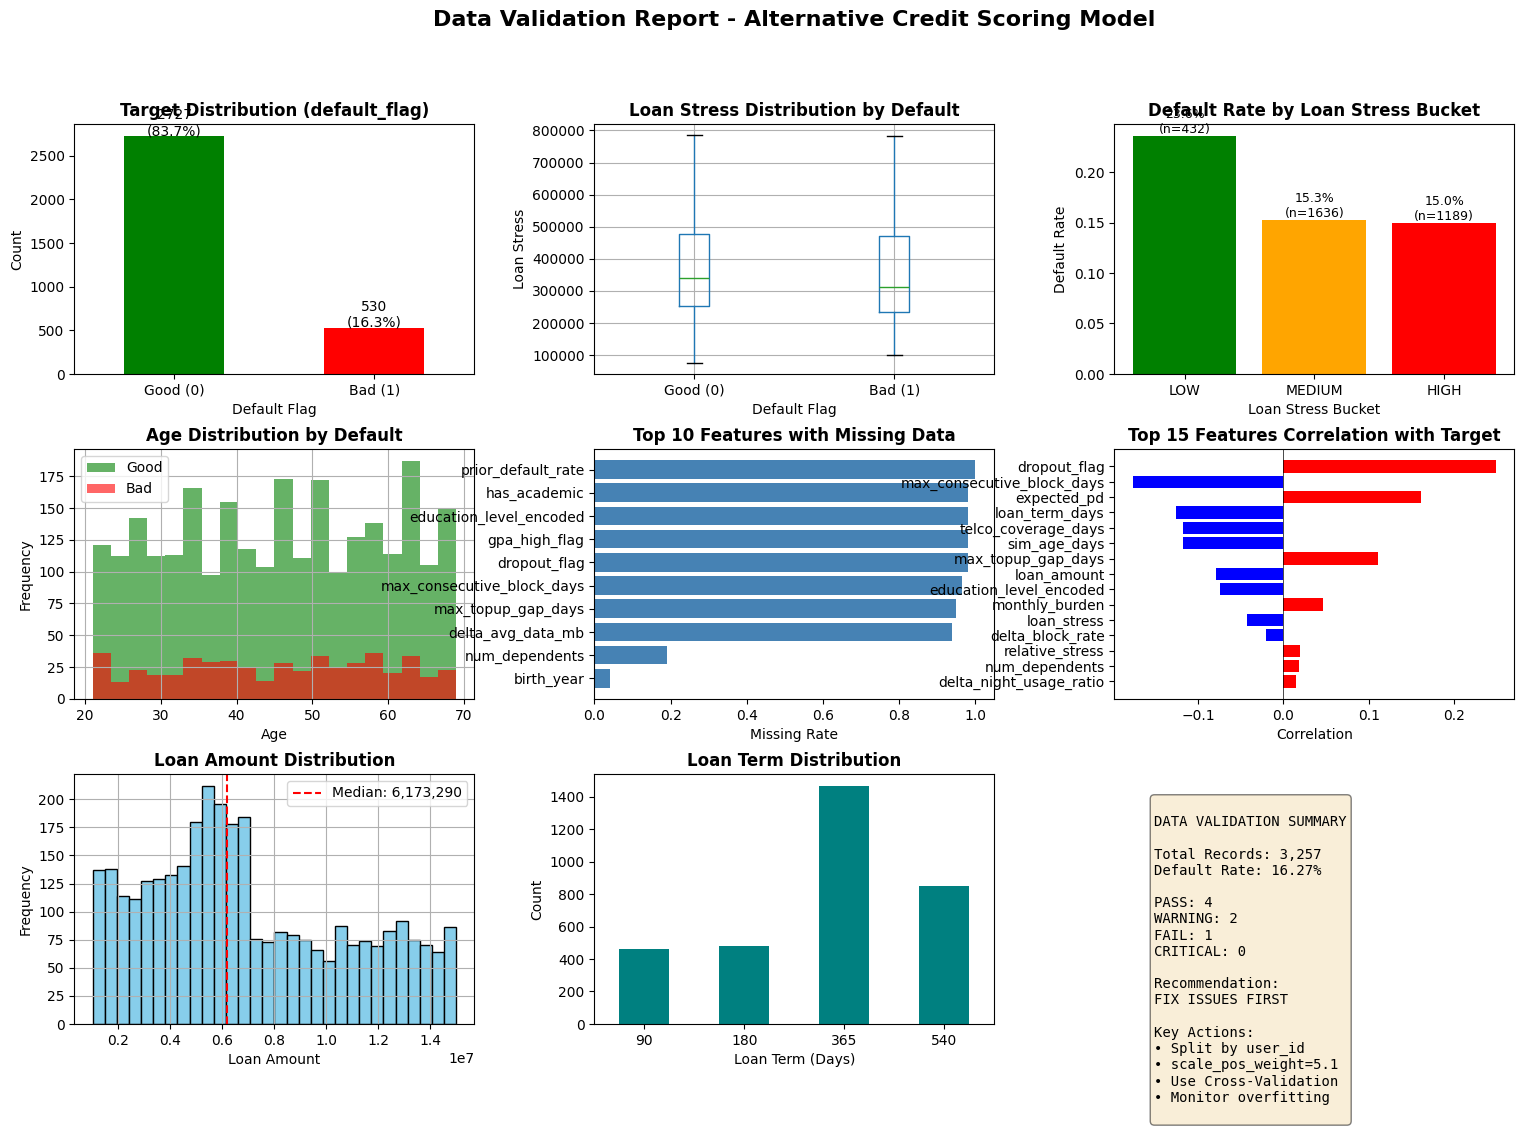


VALIDATION HOÀN TẤT!

Next steps:
1. Review các FAIL/WARNING checks
2. Fix issues nếu cần
3. Nếu PASS → Tiến hành Feature Engineering & Model Training
4. Nhớ dùng GroupShuffleSplit(groups=user_id) khi split train/test


In [28]:
# Visualization report
print("\n" + "="*80)
print("GENERATING VISUALIZATION REPORT...")
print("="*80)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Target Distribution
ax1 = fig.add_subplot(gs[0, 0])
df['default_flag'].value_counts().plot(kind='bar', ax=ax1, color=['green', 'red'])
ax1.set_title('Target Distribution (default_flag)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Default Flag')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Good (0)', 'Bad (1)'], rotation=0)
for i, v in enumerate(df['default_flag'].value_counts().values):
    ax1.text(i, v + 10, f'{v}\n({v/len(df)*100:.1f}%)', ha='center')

# Plot 2: Loan Stress Distribution by Default
ax2 = fig.add_subplot(gs[0, 1])
df.boxplot(column='loan_stress', by='default_flag', ax=ax2)
ax2.set_title('Loan Stress Distribution by Default', fontsize=12, fontweight='bold')
ax2.set_xlabel('Default Flag')
ax2.set_ylabel('Loan Stress')
plt.sca(ax2)
plt.xticks([1, 2], ['Good (0)', 'Bad (1)'])

# Plot 3: Default Rate by Loan Stress Bucket
ax3 = fig.add_subplot(gs[0, 2])
if 'loan_stress_bucket' in df.columns:
    default_by_bucket = df.groupby('loan_stress_bucket')['default_flag'].agg(['mean', 'count'])
    default_by_bucket = default_by_bucket.reindex(['LOW', 'MEDIUM', 'HIGH'])
    ax3.bar(default_by_bucket.index, default_by_bucket['mean'], color=['green', 'orange', 'red'])
    ax3.set_title('Default Rate by Loan Stress Bucket', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Default Rate')
    ax3.set_xlabel('Loan Stress Bucket')
    
    for i, (idx, row) in enumerate(default_by_bucket.iterrows()):
        ax3.text(i, row['mean'], f"{row['mean']:.1%}\n(n={int(row['count'])})", 
                ha='center', va='bottom', fontsize=9)

# Plot 4: Age Distribution by Default
ax4 = fig.add_subplot(gs[1, 0])
if 'age' in df.columns:
    df[df['default_flag']==0]['age'].hist(bins=20, alpha=0.6, label='Good', ax=ax4, color='green')
    df[df['default_flag']==1]['age'].hist(bins=20, alpha=0.6, label='Bad', ax=ax4, color='red')
    ax4.set_title('Age Distribution by Default', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Age')
    ax4.set_ylabel('Frequency')
    ax4.legend()

# Plot 5: Missing Data Heatmap
ax5 = fig.add_subplot(gs[1, 1])
top_missing = df[feature_cols].isnull().mean().sort_values(ascending=False).head(10)
ax5.barh(top_missing.index, top_missing.values, color='steelblue')
ax5.set_title('Top 10 Features with Missing Data', fontsize=12, fontweight='bold')
ax5.set_xlabel('Missing Rate')
ax5.invert_yaxis()

# Plot 6: Correlation Heatmap (Top 15 vs target)
ax6 = fig.add_subplot(gs[1, 2])
top_corr_features = corr_with_target.abs().nlargest(16).index.tolist()
top_corr_features.remove('default_flag')
corr_subset = df_check[top_corr_features + ['default_flag']].corr()['default_flag'].drop('default_flag')
colors = ['red' if x > 0 else 'blue' for x in corr_subset.values]
ax6.barh(corr_subset.index, corr_subset.values, color=colors)
ax6.set_title('Top 15 Features Correlation with Target', fontsize=12, fontweight='bold')
ax6.set_xlabel('Correlation')
ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax6.invert_yaxis()

# Plot 7: Loan Amount Distribution
ax7 = fig.add_subplot(gs[2, 0])
df['loan_amount'].hist(bins=30, ax=ax7, color='skyblue', edgecolor='black')
ax7.set_title('Loan Amount Distribution', fontsize=12, fontweight='bold')
ax7.set_xlabel('Loan Amount')
ax7.set_ylabel('Frequency')
ax7.axvline(df['loan_amount'].median(), color='red', linestyle='--', label=f'Median: {df["loan_amount"].median():,.0f}')
ax7.legend()

# Plot 8: Loan Term Distribution
ax8 = fig.add_subplot(gs[2, 1])
df['loan_term_days'].value_counts().sort_index().plot(kind='bar', ax=ax8, color='teal')
ax8.set_title('Loan Term Distribution', fontsize=12, fontweight='bold')
ax8.set_xlabel('Loan Term (Days)')
ax8.set_ylabel('Count')
ax8.tick_params(axis='x', rotation=0)

# Plot 9: Validation Summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
summary_text = f"""
DATA VALIDATION SUMMARY

Total Records: {len(df):,}
Default Rate: {default_rate:.2%}

PASS: {len(checks) - n_fail - n_warning - n_critical}
WARNING: {n_warning}
FAIL: {n_fail}
CRITICAL: {n_critical}

Recommendation:
{'GOOD TO TRAIN' if n_critical == 0 and n_fail == 0 else 'FIX ISSUES FIRST'}

Key Actions:
• Split by user_id
• scale_pos_weight={n_good/n_bad:.1f}
• Use Cross-Validation
• Monitor overfitting
"""
ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Data Validation Report - Alternative Credit Scoring Model', 
             fontsize=16, fontweight='bold', y=0.995)

# Save figure
plt.savefig('../../output/plots/data_validation_report.png', dpi=150, bbox_inches='tight')
print("Visualization saved to: output/plots/data_validation_report.png")
plt.show()

print("\n" + "="*80)
print("VALIDATION HOÀN TẤT!")
print("="*80)
print("\nNext steps:")
print("1. Review các FAIL/WARNING checks")
print("2. Fix issues nếu cần")
print("3. Nếu PASS → Tiến hành Feature Engineering & Model Training")
print("4. Nhớ dùng GroupShuffleSplit(groups=user_id) khi split train/test")
print("="*80)